<a href="https://colab.research.google.com/github/c-cadona/gama/blob/main/1_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Preparando ambiente

### 1.1 Adicionando bibliotecas

In [18]:
# Importar PyTorch
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# Importar bibliotecas adicionais
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


### 1.2 Linkando com a nuvem - Comet

https://www.comet.com/site/

In [19]:
# Instalando a lib para linkar com a nuvem
!pip install comet_ml

In [20]:
from comet_ml import Experiment

experiment = Experiment(
  api_key="nd2UQRjezn5yQPQ700efTWS2R",
  project_name="task-gamma",
  workspace="c-cadona"
)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : annoyed_sedan_8902
COMET INFO:     url                   : https://www.comet.com/c-cadona/task-gamma/61d4a720125a40a89dc20ea2f3d4d1e2
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1nmivWPdchvo-amZzILxZZcZswV7Yj3Rq
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET

## 2. Getting the dataset

In [21]:
import os
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho para a pasta "Task - GAMMA"
base_path = "/content/drive/MyDrive/Task - GAMMA"

# Verifica se já existe o link simbólico e remove antes de recriar
if os.path.exists("folsom_dataset") or os.path.islink("folsom_dataset"):
    os.unlink("folsom_dataset")  # Remove o link simbólico ou diretório existente

# Criar link simbólico para facilitar o acesso
os.symlink(os.path.join(base_path, "folsom_dataset"), "folsom_dataset")
print("Symbolic link created.")

# Listar arquivos dentro da pasta folsom_dataset
print("Arquivos na pasta folsom_dataset:", os.listdir("folsom_dataset"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Symbolic link created.
Arquivos na pasta folsom_dataset: ['folsom_images.zip', 'test_timestamps.pkl', 'Folsom_irradiance.csv', 'df_date_modif.csv', 'hparams.json', 'leitura_arquivos.ipynb', 'README.txt']


In [22]:
# unzippar as imagens dentro da VM do colab, para nao ocupar disco do drive
!unzip folsom_dataset/folsom_images.zip

Archive:  folsom_dataset/folsom_images.zip
replace 2015/10/16/20151016_220859.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [23]:
import pandas as pd

# date modified das imagens
df_date_modif = pd.read_csv("folsom_dataset/df_date_modif.csv", index_col=0, parse_dates=True)
df_date_modif

,date_modified,path
time_stamps,,
2014-01-02 15:28:08,2014-01-02 15:27:55,2014/01/02/20140102_152808.npy
2014-01-02 15:29:07,2014-01-02 15:28:53,2014/01/02/20140102_152907.npy
2014-01-02 15:30:08,2014-01-02 15:29:54,2014/01/02/20140102_153008.npy
2014-01-02 15:31:08,2014-01-02 15:30:54,2014/01/02/20140102_153108.npy
2014-01-02 15:32:08,2014-01-02 15:31:55,2014/01/02/20140102_153208.npy
...,...,...
2016-12-31 00:43:00,2016-12-31 00:31:39,2016/12/31/20161231_004300.npy
2016-12-31 00:44:00,2016-12-31 00:32:39,2016/12/31/20161231_004400.npy
2016-12-31 00:45:00,2016-12-31 00:33:39,2016/12/31/20161231_004500.npy


In [24]:
# dados de irradiance
df_irradiance = pd.read_csv("folsom_dataset/Folsom_irradiance.csv", index_col=0, parse_dates=True)
df_irradiance

,ghi,dni,dhi
timeStamp,,,
2014-01-02 08:00:00,0.0,0.0,0.0
2014-01-02 08:01:00,0.0,0.0,0.0
2014-01-02 08:02:00,0.0,0.0,0.0
2014-01-02 08:03:00,0.0,0.0,0.0
2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...
2016-12-31 07:55:00,0.0,0.0,0.0
2016-12-31 07:56:00,0.0,0.0,0.0
2016-12-31 07:57:00,0.0,0.0,0.0


In [25]:
import pickle

# timestamps do conjunto de teste utilizado, LEVANDO EM CONSIDERAÇÃO O DATE MODIFIED COMO DATA REAL DAS IMAGENS
with open("folsom_dataset/test_timestamps.pkl", "rb") as f:
    test_timestamps = pd.to_datetime(pickle.load(f))
test_timestamps

DatetimeIndex(['2016-01-01 16:30:24', '2016-01-01 16:31:24',
               '2016-01-01 16:32:24', '2016-01-01 16:33:24',
               '2016-01-01 16:34:24', '2016-01-01 16:35:24',
               '2016-01-01 16:36:24', '2016-01-01 16:37:24',
               '2016-01-01 16:38:24', '2016-01-01 16:39:24',
               ...
               '2016-12-30 23:35:39', '2016-12-30 23:36:39',
               '2016-12-30 23:37:39', '2016-12-30 23:38:39',
               '2016-12-30 23:39:39', '2016-12-30 23:40:39',
               '2016-12-30 23:41:39', '2016-12-30 23:42:39',
               '2016-12-30 23:43:39', '2016-12-30 23:44:39'],
              dtype='datetime64[ns]', length=220755, freq=None)

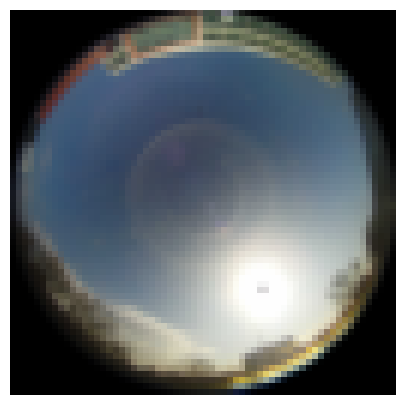

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(np.load(df_date_modif["path"].iloc[12345]))
ax.set_axis_off()

In [27]:
# hparams de treinamento
import json

with open("folsom_dataset/hparams.json", "r") as f:
    hparams = json.load(f)

batch_size = hparams["ResNet50"]["batch_size"]
learning_rate = hparams["ResNet50"]["learning_rate"]
dropout = hparams["ResNet50"]["dropout"]

### 2.1 Criando a classe dataset

In [28]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [29]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

class FolsomDataset(Dataset):
  def __init__(self, df_date_modif, df_irradiance, transform=None):
    """
    Dataset personalizado para carregar imagens e valores de irradiância.

    Args:
      df_date_modif (DataFrame): Contém os caminhos das imagens.
      df_irradiance (DataFrame): Contém os valores de irradiância indexados pelo timestamp.
      transform (callable, optional): Transformações a serem aplicadas às imagens.
    """
    self.df_date_modif = df_date_modif
    self.df_irradiance = df_irradiance
    self.transform = transform

    # Criando a lista de amostras (imagem, irradiância)
    self.data = []
    for timestamp in self.df_date_modif.index:
      if timestamp in self.df_irradiance.index:
        image_path = self.df_date_modif.loc[timestamp, "path"]
        irradiance_value = self.df_irradiance.loc[timestamp]["ghi"]
        self.data.append((image_path, irradiance_value))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_path, irradiance_value = self.data[idx]

    # Carregando a imagem .npy e convertendo para PIL Image
    image_data = np.load(image_path)
    image = Image.fromarray(image_data.astype(np.uint8))  # Converte para PIL

    if self.transform:
      image = self.transform(image)
    else:
      image = torch.from_numpy(image_data).float()
      if image.ndimension() == 3 and image.shape[-1] in [1, 3]:
        image = image.permute(2, 0, 1)  # Garantindo formato [C, H, W]

    # Convertendo a irradiância para tensor
    irradiance_value = torch.tensor(irradiance_value, dtype=torch.float32)

    return image, irradiance_value


### 2.2 Carregando DataLoader

In [30]:
import random

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)


In [31]:
# Criando os datasets (treino e teste)
train_dataset = FolsomDataset(df_date_modif, df_irradiance, transform=transform)
test_dataset = FolsomDataset(df_date_modif, df_irradiance, transform=transform)

# # Criando os DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
# num_workers=2)

# Criando sub sets
half_sets = len(train_dataset) // 2

train_subset = torch.utils.data.Subset(train_dataset, range(half_sets))
test_subset = torch.utils.data.Subset(test_dataset, range(half_sets))

# Criando os DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

## 3. Modelo Resnet50

### 3.1 Escolhendo o modelo

In [32]:
resnet50 = models.resnet50(weights="DEFAULT")

resnet50.fc = nn.Sequential(
  nn.Dropout(hparams["ResNet50"]["dropout"]),
  nn.Linear(resnet50.fc.in_features, 1)
)


loss_fn = nn.MSELoss()

optimizer = optim.AdamW(resnet50.parameters(), lr=hparams["ResNet50"]["learning_rate"], weight_decay=hparams["ResNet50"]["weight_decay"])

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(1/10) ** (1/(0.75 * hparams["ResNet50"]["epochs"])))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3.2 Treinando Modelo

In [33]:
epochs = hparams["ResNet50"]["epochs"]

for epoch in range(epochs):
  resnet50.train()

  running_loss = 0.0

  for images, targets in train_loader:
    images, targets = images.to(device), targets.to(device)

    # Set the optimizer
    optimizer.zero_grad()
    outputs = resnet50(images).squeeze()

    # Set the loss
    loss = loss_fn(outputs, targets)
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Somando a loss
    running_loss += loss.item()

  scheduler.step()
  print(f"Epoch {epoch+1}/{epochs}, Loss: {(running_loss/len(train_loader)):.4f}, LR: {(scheduler.get_last_lr()[0]):.9f}")



Época 1/16, Loss: 20680.6704, LR: 0.000660323
Época 2/16, Loss: 3540.0123, LR: 0.000545034
Época 3/16, Loss: 2885.4553, LR: 0.000449873
Época 4/16, Loss: 2224.8390, LR: 0.000371327
Época 5/16, Loss: 1548.9163, LR: 0.000306495
Época 6/16, Loss: 1085.8570, LR: 0.000252982
Época 7/16, Loss: 794.9430, LR: 0.000208813
Época 8/16, Loss: 595.5203, LR: 0.000172355
Época 9/16, Loss: 440.2152, LR: 0.000142262
Época 10/16, Loss: 338.7473, LR: 0.000117424
Época 11/16, Loss: 273.6519, LR: 0.000096922
Época 12/16, Loss: 227.5279, LR: 0.000080000
Época 13/16, Loss: 190.1790, LR: 0.000066032
Época 14/16, Loss: 163.5397, LR: 0.000054503
Época 15/16, Loss: 143.1039, LR: 0.000044987
Época 16/16, Loss: 131.3960, LR: 0.000037133


## 4. Avaliando o modelo

### 4.0 Making predictions

In [34]:
import numpy as np
import torch

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

def predict(model, dataloader, device):
  model.eval()
  predictions = []
  with torch.inference_mode():

    for images, _ in dataloader:
      images = images.to(device)
      outputs = model(images).squeeze()
      predictions.extend(outputs.cpu().numpy())

  return np.array(predictions)

### 4.1 RMSE e MAE

In [37]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [40]:
import torch
import torchmetrics

def evaluate_model(model, dataloader, device):
  model.eval()
  predictions, ground_truths = [], []

  with torch.inference_mode():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      outputs = model(images).squeeze()

      predictions.extend(outputs.cpu())
      ground_truths.extend(targets.cpu())

  predictions = torch.tensor(predictions)
  ground_truths = torch.tensor(ground_truths)

  rmse = torchmetrics.functional.mean_squared_error(predictions, ground_truths).sqrt()
  mae = torchmetrics.functional.mean_absolute_error(predictions, ground_truths)
  r2 = torchmetrics.functional.r2_score(predictions, ground_truths)

  return rmse.item(), mae.item(), r2.item()

rmse, mae, r2 = evaluate_model(resnet50, test_loader, device)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


RMSE: 8.0185, MAE: 5.7665, R2: 0.9993
